## All needed imports

In [81]:
import pandas as pd                      # pandas is a dataframe library
import matplotlib.pyplot as plt          # matpoltlib.pypolt plots data
import numpy as np                       # numpy provides N-dim object support
import seaborn as sns
from apyori import apriori

from sklearn import model_selection
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer      # importing class imputer to replace zero missing values with mean values 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text  # both are new in 0.21
from sklearn.neighbors import KNeighborsClassifier

from plotly import __version__
from plotly.graph_objs import FigureWidget
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# do plotting inline instead of in a separate window
%matplotlib inline

seed = 42

## Load and Review data with converting strings to integers

In [82]:
def conv_binary(cell):
    if(cell == 'satisfied' or cell == 'Loyal Customer' or cell == 'Male' or cell == 'Personal Travel' or cell == 'Eco'):
        return 1
    elif(cell == 'Eco Plus'):
        return 2
    else:
        return 0

def expandRate(dataf, cell):
    return dataf.merge(dataf[cell].apply(lambda s: pd.Series({'Excellent'+cell: int(s > 3), 'Good'+cell: int(1 < s < 4), 'Bad'+cell: int(s < 2)})), 
                        left_index=True, right_index=True)

In [83]:
#loading pima data. Adjust path if necessary
df = pd.read_excel("./satisfaction.xlsx", converters={
    #"satisfaction_v2" : conv_binary,
    "Gender" : conv_binary,
    "Type of Travel" : conv_binary,
    "Class" : conv_binary,
    "Customer Type" : conv_binary
})

df_assoc = df.copy()
# df = pd.read_excel("./satisfaction.xlsx")

In [84]:
df.shape   # number of rows and number of cols

(129880, 24)

In [85]:
df.head(5)  # display data

id satisfaction_v2  Gender  Customer Type  Age  Type of Travel  Class  \
0   11112       satisfied       0              1   65               1      1   
1  110278       satisfied       1              1   47               1      0   
2  103199       satisfied       0              1   15               1      1   
3   47462       satisfied       0              1   60               1      1   
4  120011       satisfied       0              1   70               1      1   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  ...  \
0              265             0                                  0  ...   
1             2464             0                                  0  ...   
2             2138             0                                  0  ...   
3              623             0                                  0  ...   
4              354             0                                  0  ...   

   Online support  Ease of Online booking  On-board service  Leg room service  \
0               2                       3                 3                 0   
1               2                       3                 4                 4   
2               2                       2                 3                 3   
3               3                       1                 1                 0   
4               4                       2                 2                 0   

   Baggage handling  Checkin service  Cleanliness  Online boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   

   Departure Delay in Minutes  Arrival Delay in Minutes  
0                           0                       0.0  
1                         310                     305.0  
2                           0                       0.0  
3                           0                       0.0  
4                           0                       0.0  

[5 rows x 24 columns]

In [86]:
df.tail(15)   # dispay the end of the data

id          satisfaction_v2  Gender  Customer Type  Age  \
129865   82526                satisfied       0              0   59   
129866   51023                satisfied       0              0   18   
129867   86234                satisfied       0              0   30   
129868    8518                satisfied       0              0   45   
129869   80330                satisfied       0              0   55   
129870   22432                satisfied       0              0   70   
129871   91851                satisfied       0              0   35   
129872   41573                satisfied       0              0   69   
129873   46936                satisfied       0              0   63   
129874   53969                satisfied       0              0   11   
129875  119211                satisfied       0              0   29   
129876   97768  neutral or dissatisfied       1              0   63   
129877  125368  neutral or dissatisfied       1              0   69   
129878     251  neutral or dissatisfied       1              0   66   
129879   84566  neutral or dissatisfied       0              0   38   

        Type of Travel  Class  Flight Distance  Seat comfort  \
129865               1      1             2641             4   
129866               1      1             1243             5   
129867               1      1             1961             5   
129868               1      1             1612             5   
129869               1      1             1953             5   
129870               1      1             1674             5   
129871               1      1             3287             5   
129872               1      1             2240             5   
129873               1      1             1942             5   
129874               1      1             2752             5   
129875               1      1             1731             5   
129876               1      0             2087             2   
129877               1      1             2320             3   
129878               1      1             2450             3   
129879               1      1             4307             3   

        Departure/Arrival time convenient  ...  Online support  \
129865                                  5  ...               2   
129866                                  0  ...               2   
129867                                  1  ...               5   
129868                                  2  ...               2   
129869                                  2  ...               5   
129870                                  4  ...               5   
129871                                  4  ...               2   
129872                                  4  ...               4   
129873                                  5  ...               3   
129874                                  5  ...               2   
129875                                  5  ...               2   
129876                                  3  ...               1   
129877                                  0  ...               2   
129878                                  2  ...               2   
129879                                  4  ...               3   

        Ease of Online booking  On-board service  Leg room service  \
129865                       2                 1                 5   
129866                       2                 4                 5   
129867                       5                 3                 2   
129868                       2                 2                 5   
129869                       1                 1                 1   
129870                       5                 3                 2   
129871                       2                 4                 5   
129872                       4                 5                 4   
129873                       3                 5                 2   
129874                       2                 3                 5   
129875                 

In [87]:
print("The dataset contains columns of the following data types : \n" + str(df.dtypes))

The dataset contains columns of the following data types : 
id                                     int64
satisfaction_v2                       object
Gender                                 int64
Customer Type                          int64
Age                                    int64
Type of Travel                         int64
Class                                  int64
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            i

**This explanation about this dataset**
* **Satisfaction:** Airline satisfaction level(Satisfaction, neutral or dissatisfaction)
* **Age:** The actual age of the passengers
* **Gender:** Gender of the passengers (Female, Male)
* **Type of Travel:** Purpose of the flight of the passengers (Personal Travel, Business Travel)
* **Class:** Travel class in the plane of the passengers (Business, Eco, Eco Plus)
* **Customer Type:** The customer type (Loyal customer, disloyal customer)
* **Flight distance:** The flight distance of this journey
* **Inflight wifi service:** Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
* **Ease of Online booking:** Satisfaction level of online booking
* **Inflight service:** Satisfaction level of inflight service
* **Online boarding:** Satisfaction level of online boarding
* **Inflight entertainment:** Satisfaction level of inflight entertainment
* **Food and drink:** Satisfaction level of Food and drink
* **Seat comfort:** Satisfaction level of Seat comfort
* **On-board service:** Satisfaction level of On-board service
* **Leg room service:** Satisfaction level of Leg room service
* **Departure/Arrival time convenient:** Satisfaction level of Departure/Arrival time convenient
* **Baggage handling:** Satisfaction level of baggage handling
* **Gate location:** Satisfaction level of Gate location
* **Cleanliness:** Satisfaction level of Cleanliness
* **Check-in service:** Satisfaction level of Check-in service
* **Departure Delay in Minutes:** Minutes delayed when departure
* **Arrival Delay in Minutes:** Minutes delayed when Arrival

In [88]:
df.isnull().values.any()   # check if there are any null values exist

True

In [95]:
df.isnull().any()

id                                   False
satisfaction_v2                      False
Gender                               False
Customer Type                        False
Age                                  False
Type of Travel                       False
Class                                False
Flight Distance                      False
Seat comfort                         False
Departure/Arrival time convenient    False
Food and drink                       False
Gate location                        False
Inflight wifi service                False
Inflight entertainment               False
Online support                       False
Ease of Online booking               False
On-board service                     False
Leg room service                     False
Baggage handling                     False
Checkin service                      False
Cleanliness                          False
Online boarding                      False
Departure Delay in Minutes           False
Arrival Del

In [9]:
df = df.dropna() # drop all nan values

In [10]:
df.isnull().values.any()   # check if there are any null values exist

False

In [11]:
df.shape

(129487, 24)

In [12]:
df['satisfaction_v2'].value_counts()

satisfied                  70882
neutral or dissatisfied    58605
Name: satisfaction_v2, dtype: int64

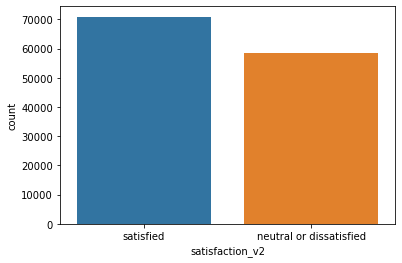

In [13]:
sns.countplot(x='satisfaction_v2',data=df)

In [14]:
df['satisfaction_v2'] = df['satisfaction_v2'].apply(conv_binary)    

In [15]:
df.head()

id  satisfaction_v2  Gender  Customer Type  Age  Type of Travel  Class  \
0   11112                1       0              1   65               1      1   
1  110278                1       1              1   47               1      0   
2  103199                1       0              1   15               1      1   
3   47462                1       0              1   60               1      1   
4  120011                1       0              1   70               1      1   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  ...  \
0              265             0                                  0  ...   
1             2464             0                                  0  ...   
2             2138             0                                  0  ...   
3              623             0                                  0  ...   
4              354             0                                  0  ...   

   Online support  Ease of Online booking  On-board service  Leg room service  \
0               2                       3                 3                 0   
1               2                       3                 4                 4   
2               2                       2                 3                 3   
3               3                       1                 1                 0   
4               4                       2                 2                 0   

   Baggage handling  Checkin service  Cleanliness  Online boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   

   Departure Delay in Minutes  Arrival Delay in Minutes  
0                           0                       0.0  
1                         310                     305.0  
2                           0                       0.0  
3                           0                       0.0  
4                           0                       0.0  

[5 rows x 24 columns]

In [16]:
def plot_corr(df, size=24):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.
    
    Input:
        df: pandas DataFrame
        size: vertical and Horizontal size of the plot
        
        Displays:
            matrix of correlation between columns.  darkblue-Blue-cyan-red-yellow => less to more correlated
                                                    0 -----------------> 1
                                                    Expect a darkred line running from top left to bottom right.
    """
    corr = df.corr()     # dataframe correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)   # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)   # draw y tick marks

def plot_corr_v2(df):
    fig = plt.figure(figsize=(18,10))
    sns.heatmap(df.corr(),annot=True)
    plt.tight_layout()

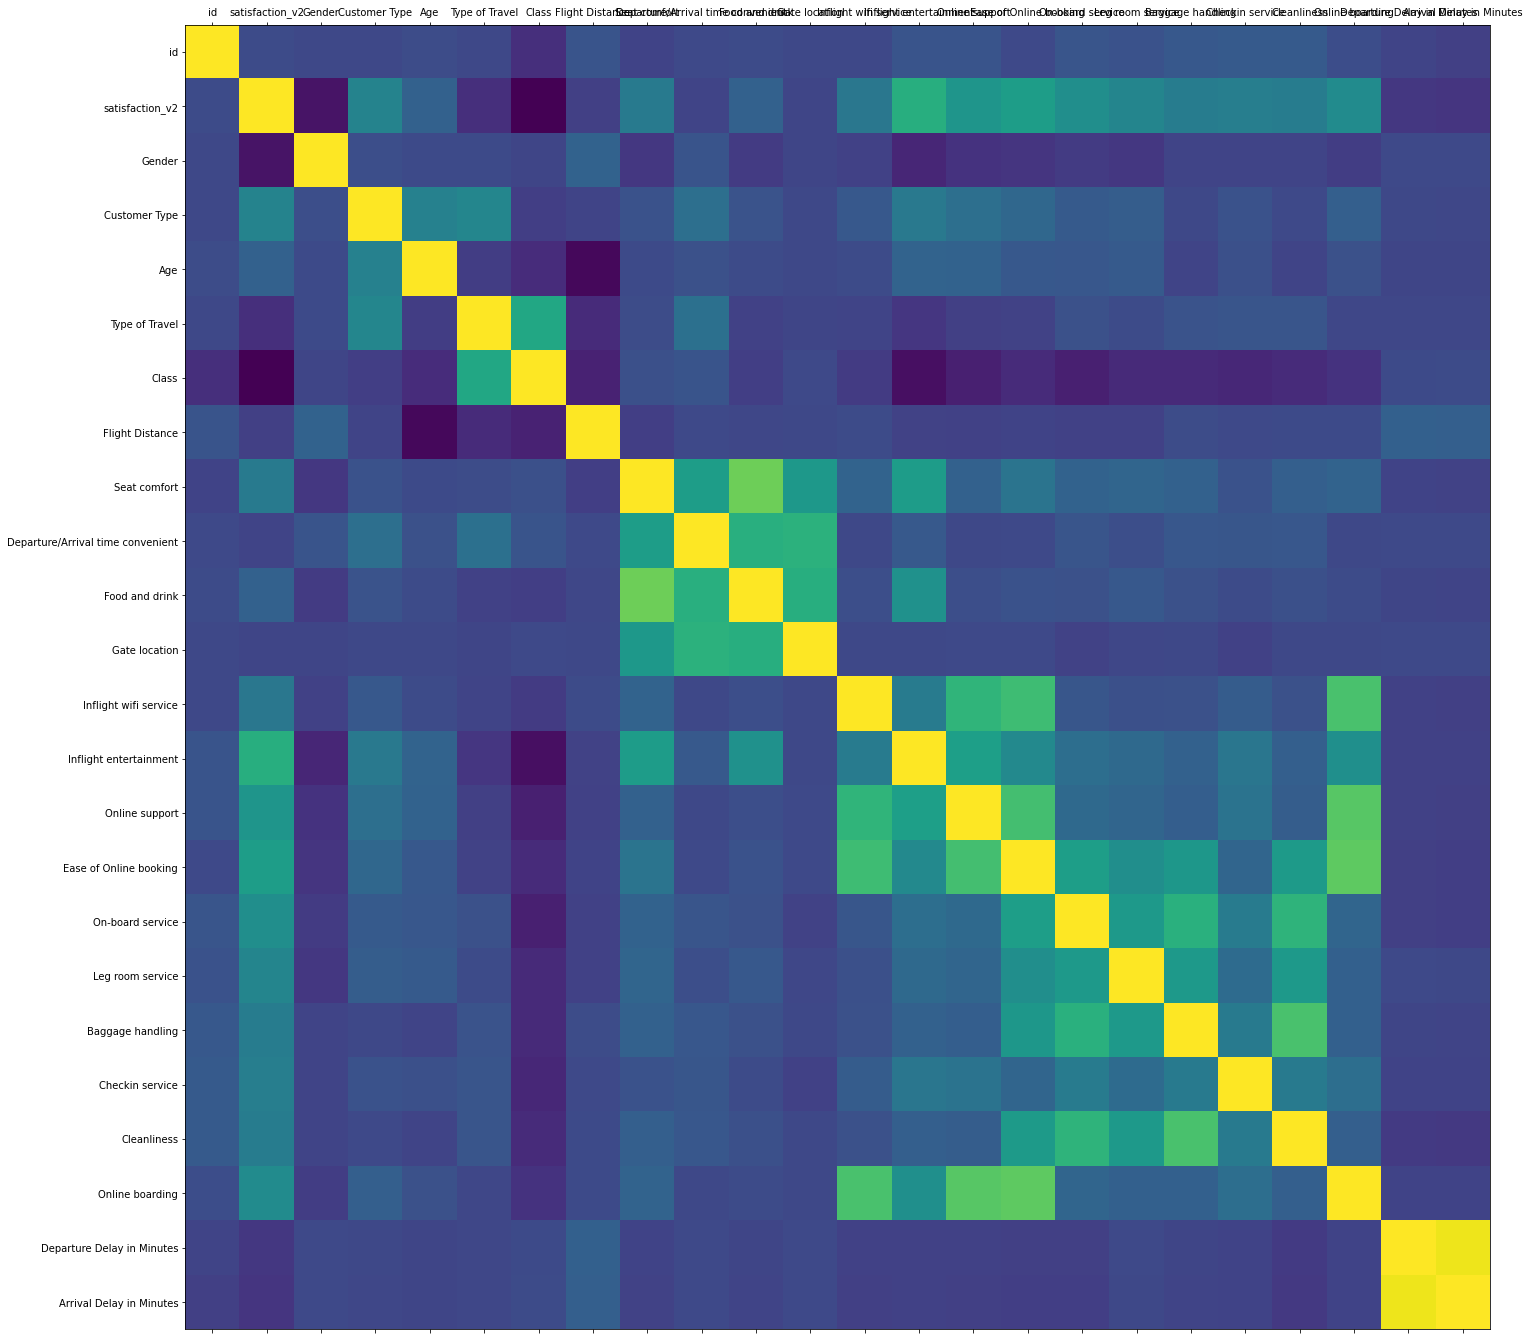

In [17]:
plot_corr(df)

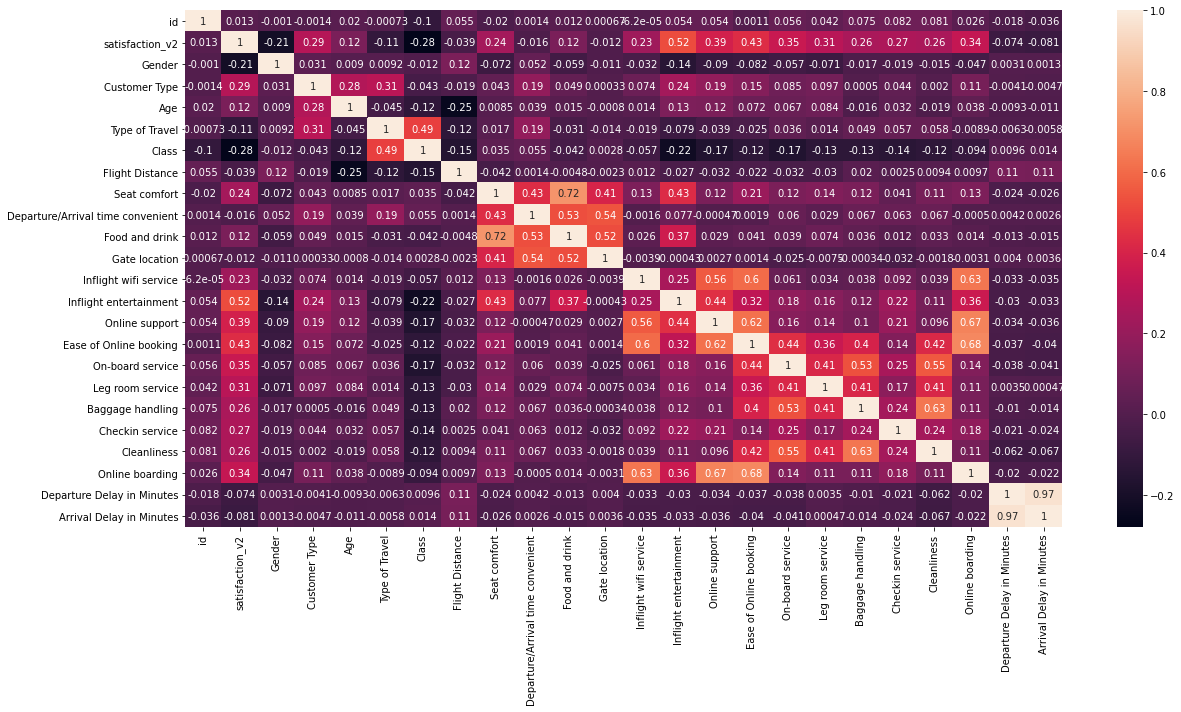

In [18]:
plot_corr_v2(df)

   _From this graph we try using features with correlation more than 0.1 with our target's satisfaction._

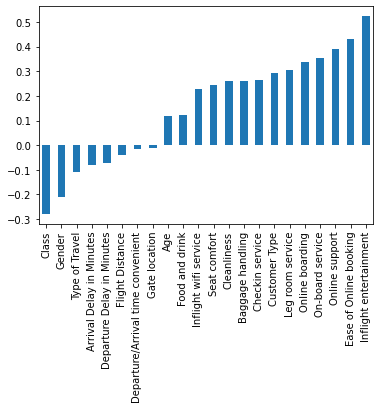

In [19]:
df.corr()['satisfaction_v2'].sort_values().drop(['id','satisfaction_v2']).plot(kind='bar')

In [20]:
df['Inflight entertainment'].value_counts()

4    41752
5    29748
3    24133
2    19118
1    11768
0     2968
Name: Inflight entertainment, dtype: int64

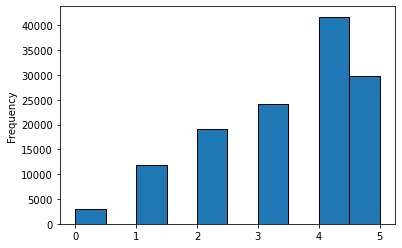

In [21]:
df['Inflight entertainment'].plot(kind='hist',ec='black')

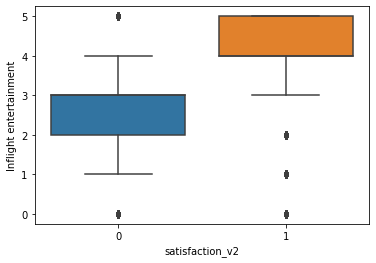

In [22]:
sns.boxplot(x='satisfaction_v2',y = 'Inflight entertainment',data=df)

**_The more satisfied the person is with Inflight entertainment then there are greater chances that the person will be satisfied.<br>Same is the case for all the other correlated parameters._**

Now, let's check the correlation of Inflight entertainment with others.

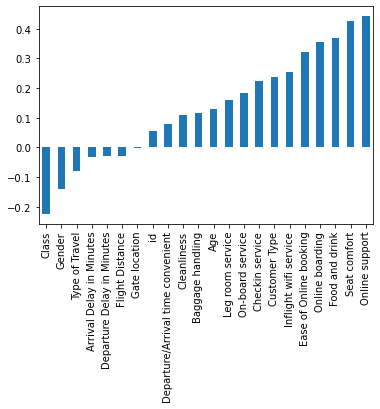

In [23]:
df.corr()['Inflight entertainment'].sort_values().drop(['Inflight entertainment','satisfaction_v2']).plot(kind='bar')

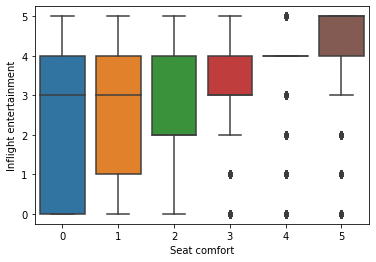

In [24]:
sns.boxplot(x='Seat comfort',y = 'Inflight entertainment',data=df)

_People who gets better seat comfort are likely to have inflight entertainment and gives better rating._

In [25]:
df['Flight Distance'].iplot(kind='hist',bins=50)

Most of the flights are between 1000 to 3000 kms, and there are fine number of flights between 200-400 kms

In [26]:
import plotly.express as px
fig = px.box(df, x="satisfaction_v2", y="Age", color="Class")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

From the boxplot we can infer that people who are sitting in Business class (2) between age 30 to 50 are likely to be more satisfied.

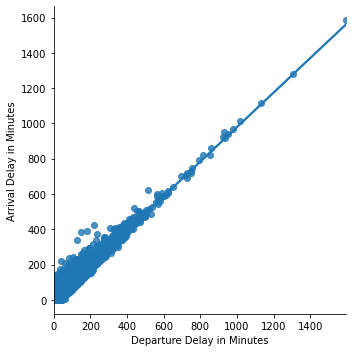

In [27]:
sns.lmplot(x='Departure Delay in Minutes',y='Arrival Delay in Minutes',data=df)

Arrival Delay and Departure delay have a linear relation, so we can drop one column

## Renaming data labels to drop cols 


In [28]:
'''
df.head()
df.rename(columns={"Food and drink":'FD',"Online boarding":'OB',
                   'Ease of Online booking':'EOOB','Online support':'OS',
                    'Baggage handling':'BH','Departure Delay in Minutes':'DDIM'}, inplace=True)
'''

'\ndf.head()\ndf.rename(columns={"Food and drink":\'FD\',"Online boarding":\'OB\',\n                   \'Ease of Online booking\':\'EOOB\',\'Online support\':\'OS\',\n                    \'Baggage handling\':\'BH\',\'Departure Delay in Minutes\':\'DDIM\'}, inplace=True)\n'

In [29]:
df.head()

id  satisfaction_v2  Gender  Customer Type  Age  Type of Travel  Class  \
0   11112                1       0              1   65               1      1   
1  110278                1       1              1   47               1      0   
2  103199                1       0              1   15               1      1   
3   47462                1       0              1   60               1      1   
4  120011                1       0              1   70               1      1   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  ...  \
0              265             0                                  0  ...   
1             2464             0                                  0  ...   
2             2138             0                                  0  ...   
3              623             0                                  0  ...   
4              354             0                                  0  ...   

   Online support  Ease of Online booking  On-board service  Leg room service  \
0               2                       3                 3                 0   
1               2                       3                 4                 4   
2               2                       2                 3                 3   
3               3                       1                 1                 0   
4               4                       2                 2                 0   

   Baggage handling  Checkin service  Cleanliness  Online boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   

   Departure Delay in Minutes  Arrival Delay in Minutes  
0                           0                       0.0  
1                         310                     305.0  
2                           0                       0.0  
3                           0                       0.0  
4                           0                       0.0  

[5 rows x 24 columns]

In [30]:
# dropping cols
##columns = ['FD', 'OB', 'EOOB','OS', 'BH', 'DDIM','id']
columns = ['Gender', 'Type of Travel', 'Class','Flight Distance', 'Departure/Arrival time convenient', 
           'Gate location', 'Departure Delay in Minutes', 'id', 'Arrival Delay in Minutes']
df.drop(columns, inplace = True, axis=1)

In [31]:
df.shape

(129487, 15)

In [32]:
df.head()

satisfaction_v2  Customer Type  Age  Seat comfort  Food and drink  \
0                1              1   65             0               0   
1                1              1   47             0               0   
2                1              1   15             0               0   
3                1              1   60             0               0   
4                1              1   70             0               0   

   Inflight wifi service  Inflight entertainment  Online support  \
0                      2                       4               2   
1                      0                       2               2   
2                      2                       0               2   
3                      3                       4               3   
4                      4                       3               4   

   Ease of Online booking  On-board service  Leg room service  \
0                       3                 3                 0   
1                       3                 4                 4   
2                       2                 3                 3   
3                       1                 1                 0   
4                       2                 2                 0   

   Baggage handling  Checkin service  Cleanliness  Online boarding  
0                 3                5            3                2  
1                 4                2            3                2  
2                 4                4            4                2  
3                 1                4            1                3  
4                 2                4            2                5

# check true and false ratio

In [33]:
num_true = len(df.loc[df['satisfaction_v2'] == True])   # satisfication statuses are true
num_false = len(df.loc[df['satisfaction_v2'] == False]) # satisfication statuses are false

print("Number of True cases: {0} ({1:2.2f}%)".format(num_true,(num_true/ (num_true + num_false)) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false,(num_false/ (num_true + num_false)) * 100))


Number of True cases: 70882 (54.74%)
Number of False cases: 58605 (45.26%)


## renaming the data

In [34]:
df.rename(columns={"Food and drink":'FD',"Online boarding":'OB',
                   'Ease of Online booking':'EOOB','Online support':'OS', 'Baggage handling':'BH', 
                   'Customer Type':'Customer_Type',
                   'Seat comfort':'Seat_comfort',
                  'Inflight wifi service':'Inflight_wifi_service',
                  'Inflight entertainment':'Inflight_entertainment',
                  'On-board service':'On_board_service', 'Leg room service':'Leg_room_service',
                  'Checkin service':'Checkin_service'}
          ,inplace=True)

In [35]:
print("Finally, the dataset contains columns of the following data types : \n" + str(df.dtypes))

Finally, the dataset contains columns of the following data types : 
satisfaction_v2           int64
Customer_Type             int64
Age                       int64
Seat_comfort              int64
FD                        int64
Inflight_wifi_service     int64
Inflight_entertainment    int64
OS                        int64
EOOB                      int64
On_board_service          int64
Leg_room_service          int64
BH                        int64
Checkin_service           int64
Cleanliness               int64
OB                        int64
dtype: object


In [36]:
df.head()

satisfaction_v2  Customer_Type  Age  Seat_comfort  FD  \
0                1              1   65             0   0   
1                1              1   47             0   0   
2                1              1   15             0   0   
3                1              1   60             0   0   
4                1              1   70             0   0   

   Inflight_wifi_service  Inflight_entertainment  OS  EOOB  On_board_service  \
0                      2                       4   2     3                 3   
1                      0                       2   2     3                 4   
2                      2                       0   2     2                 3   
3                      3                       4   3     1                 1   
4                      4                       3   4     2                 2   

   Leg_room_service  BH  Checkin_service  Cleanliness  OB  
0                 0   3                5            3   2  
1                 4   4                2            3   2  
2                 3   4                4            4   2  
3                 0   1                4            1   3  
4                 0   2                4            2   5

## Prepare data for building classification model (except Naive Bayes)

In [37]:
#from sklearn.cross_validation import train_test_split ## Omar: it's deprecated 
'''
feature_col_names = ['Gender', 'Customer_Type', 'Age', 'Type_of_Travel', 
                     'Class', 'Flight_Distance', 'Seat_comfort', 
                     'Arival_time','Gate_location','Inflight_wifi_service',
                    'Inflight_entertainment','On_board_service','Leg_room_service',
                    'Checkin_service','Cleanliness','Arrival_Delay_in_Minutes']
'''

feature_col_names = ['Customer_Type', 'Age', 'BH', 
                     'FD', 'Seat_comfort', 'Leg_room_service',
                     'OB','OS','Inflight_wifi_service',
                    'Inflight_entertainment','On_board_service',
                    'Checkin_service','Cleanliness','EOOB']
predicted_class_names = ['satisfaction_v2']


x = df[feature_col_names].values           # predictor feature columns (8 x m)
y = df[predicted_class_names].values       # predictor class (1 = true , 0 = false) column (1 x m)
split_test_size = 0.30

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_test_size, random_state=seed, stratify=y)

                            # test_size = 0.3 is 30% , 42 is the answer to everything
models = []
names = []
results = []

In [38]:
print("{0:0.2f}% in training set".format((len(x_train)/len(df.index))*100))
print("{0:0.2f}% in test set".format((len(x_test)/len(df.index))*100))

70.00% in training set
30.00% in test set


In [39]:
print("Original True : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 1]), (len(df.loc[df['satisfaction_v2'] == 1]) / len(df.index))*100))
print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 0]), (len(df.loc[df['satisfaction_v2'] == 0]) / len(df.index))*100))
print("")
print("Training True : {0} ({1:0.3f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1]) / len(y_train) * 100.0 )))
print("Training False : {0} ({1:0.3f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0]) / len(y_train) * 100.0 )))
print("")
print("Test True : {0} ({1:0.3f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1]) / len(y_test) * 100.0 )))
print("Test False : {0} ({1:0.3f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0]) / len(y_test) * 100.0 )))


Original True : 70882 (54.74%)
Original False : 58605 (45.26%)

Training True : 49617 (54.741%)
Training False : 41023 (45.259%)

Test True : 21265 (54.740%)
Test False : 17582 (45.260%)


In [40]:
#from sklearn.preprocessing import Imputer    ## Omar: it's deprecated 
#Impute with mean all 0 readings
fill_0 = SimpleImputer(missing_values=0, strategy="mean", verbose=0)  # axis=0 -> col, verbose = axis

x_train = fill_0.fit_transform(x_train)
x_test = fill_0.fit_transform(x_test)

<a id="top"></a>
# Table of Algorithms

1. [Naive Bayes](#NB)
2. [Random Forest](#RF)
3. [Decision Tree](#DT)
4. [K-Nearest Neigbors](#KNN)
5. [Logistic Regression](#LR)
6. [Gradient Boosting](#GB)

<a id='NB'></a>
## 1. Naive Bayes Algorithm
[Top](#top)

In [41]:

#from sklearn.cross_validation import train_test_split ## Omar: it's deprecated 
## Omar: Remove non categorical elements: ['Age', 'Flight_Distance', 'Arrival_Delay_in_Minutes']
categorical_feature_col_names = ['Customer_Type', 'BH', 
                     'FD', 'Seat_comfort', 'Leg_room_service',
                     'OB','OS','Inflight_wifi_service',
                    'Inflight_entertainment','On_board_service',
                    'Checkin_service','Cleanliness','EOOB']
predicted_class_names = ['satisfaction_v2']


x_cat = df[categorical_feature_col_names].values           # predictor feature columns (8 x m)
y = df[predicted_class_names].values       # predictor class (1 = true , 0 = false) column (1 x m)
split_test_size = 0.30

x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_cat, y, test_size=split_test_size, random_state=seed, stratify=y)

                            # test_size = 0.3 is 30% , 42 is the answer to everything

In [42]:
print("{0:0.2f}% in training set".format((len(x_train_cat)/len(df.index))*100))
print("{0:0.2f}% in test set".format((len(x_test_cat)/len(df.index))*100))

70.00% in training set
30.00% in test set


In [43]:
print("Original True : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 1]), (len(df.loc[df['satisfaction_v2'] == 1]) / len(df.index))*100))
print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 0]), (len(df.loc[df['satisfaction_v2'] == 0]) / len(df.index))*100))
print("")
print("Training True : {0} ({1:0.3f}%)".format(len(y_train_cat[y_train_cat[:] == 1]), (len(y_train_cat[y_train_cat[:] == 1]) / len(y_train_cat) * 100.0 )))
print("Training False : {0} ({1:0.3f}%)".format(len(y_train_cat[y_train_cat[:] == 0]), (len(y_train_cat[y_train_cat[:] == 0]) / len(y_train_cat) * 100.0 )))
print("")
print("Test True : {0} ({1:0.3f}%)".format(len(y_test_cat[y_test_cat[:] == 1]), (len(y_test_cat[y_test_cat[:] == 1]) / len(y_test_cat) * 100.0 )))
print("Test Fasle : {0} ({1:0.3f}%)".format(len(y_test_cat[y_test_cat[:] == 0]), (len(y_test_cat[y_test_cat[:] == 0]) / len(y_test_cat) * 100.0 )))


Original True : 70882 (54.74%)
Original False : 58605 (45.26%)

Training True : 49617 (54.741%)
Training False : 41023 (45.259%)

Test True : 21265 (54.740%)
Test Fasle : 17582 (45.260%)


In [44]:
#from sklearn.preprocessing import Imputer    ## Omar: it's deprecated 
#Impute with mean all 0 readings
fill_0 = SimpleImputer(missing_values=0, strategy="mean", verbose=0)  # axis=0 -> col, verbose = axis

x_train_cat = fill_0.fit_transform(x_train_cat)
x_test_cat = fill_0.fit_transform(x_test_cat)

In [45]:
# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(x_train_cat,y_train_cat.ravel());

models.append(nb_model)
names.append("NB")

In [46]:
# predict values using the training data
nb_predict_train = nb_model.predict(x_train_cat)

acc_train = metrics.accuracy_score(y_train_cat, nb_predict_train)

# predict values using the test data
nb_predict_test = nb_model.predict(x_test_cat)

acc_test = metrics.accuracy_score(y_test_cat, nb_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 79.63%
Accuracy on testing data: 79.49%


Confucsion Matrix
[[13332  4250]
 [ 3717 17548]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     17582
           1       0.81      0.83      0.81     21265

    accuracy                           0.79     38847
   macro avg       0.79      0.79      0.79     38847
weighted avg       0.79      0.79      0.79     38847



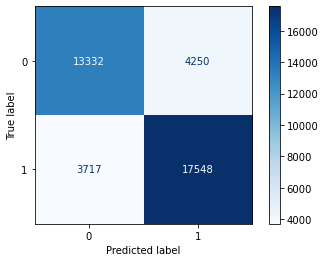

In [47]:
#print("Confucsion Matrix")   # left col predicted false , right predicted true
#print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test)))
# plot confusion matrix
confM = metrics.plot_confusion_matrix(nb_model, x_test_cat, y_test_cat, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test_cat, nb_predict_test))

<a id='RF'></a>
## 2. Random Forest Algorithm
[Top](#top)

In [48]:
# Create random forest object
rf_model = RandomForestClassifier(random_state=seed, n_estimators=10)  # n_estimators will change from 10 in version 0.20 to 100 in 0.22
rf_model.fit(x_train, y_train.ravel());

models.append(rf_model)
names.append("RF")

In [49]:
# predict values using the training data
rf_predict_train = rf_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, rf_predict_train)

# predict values using the test data
rf_predict_test = rf_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, rf_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 99.42%
Accuracy on testing data: 92.84%


Confucsion Matrix
[[16438  1144]
 [ 1638 19627]]

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     17582
           1       0.94      0.92      0.93     21265

    accuracy                           0.93     38847
   macro avg       0.93      0.93      0.93     38847
weighted avg       0.93      0.93      0.93     38847



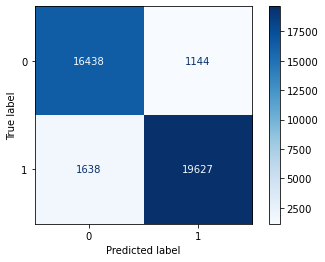

In [50]:
#print("Confucsion Matrix")   # left col predicted false , right predicted true
#print("{0}".format(metrics.confusion_matrix(y_test, rf_predict_test)))
# plot confusion matrix
confM = metrics.plot_confusion_matrix(rf_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

<a id='DT'></a>
## 3. Decision Tree Algorithm
[Top](#top)

In [51]:
# Create Decision Tree object
dt_model = DecisionTreeClassifier(random_state=seed, max_depth=10)
dt_model.fit(x_train, y_train.ravel());

models.append(dt_model)
names.append("DT")

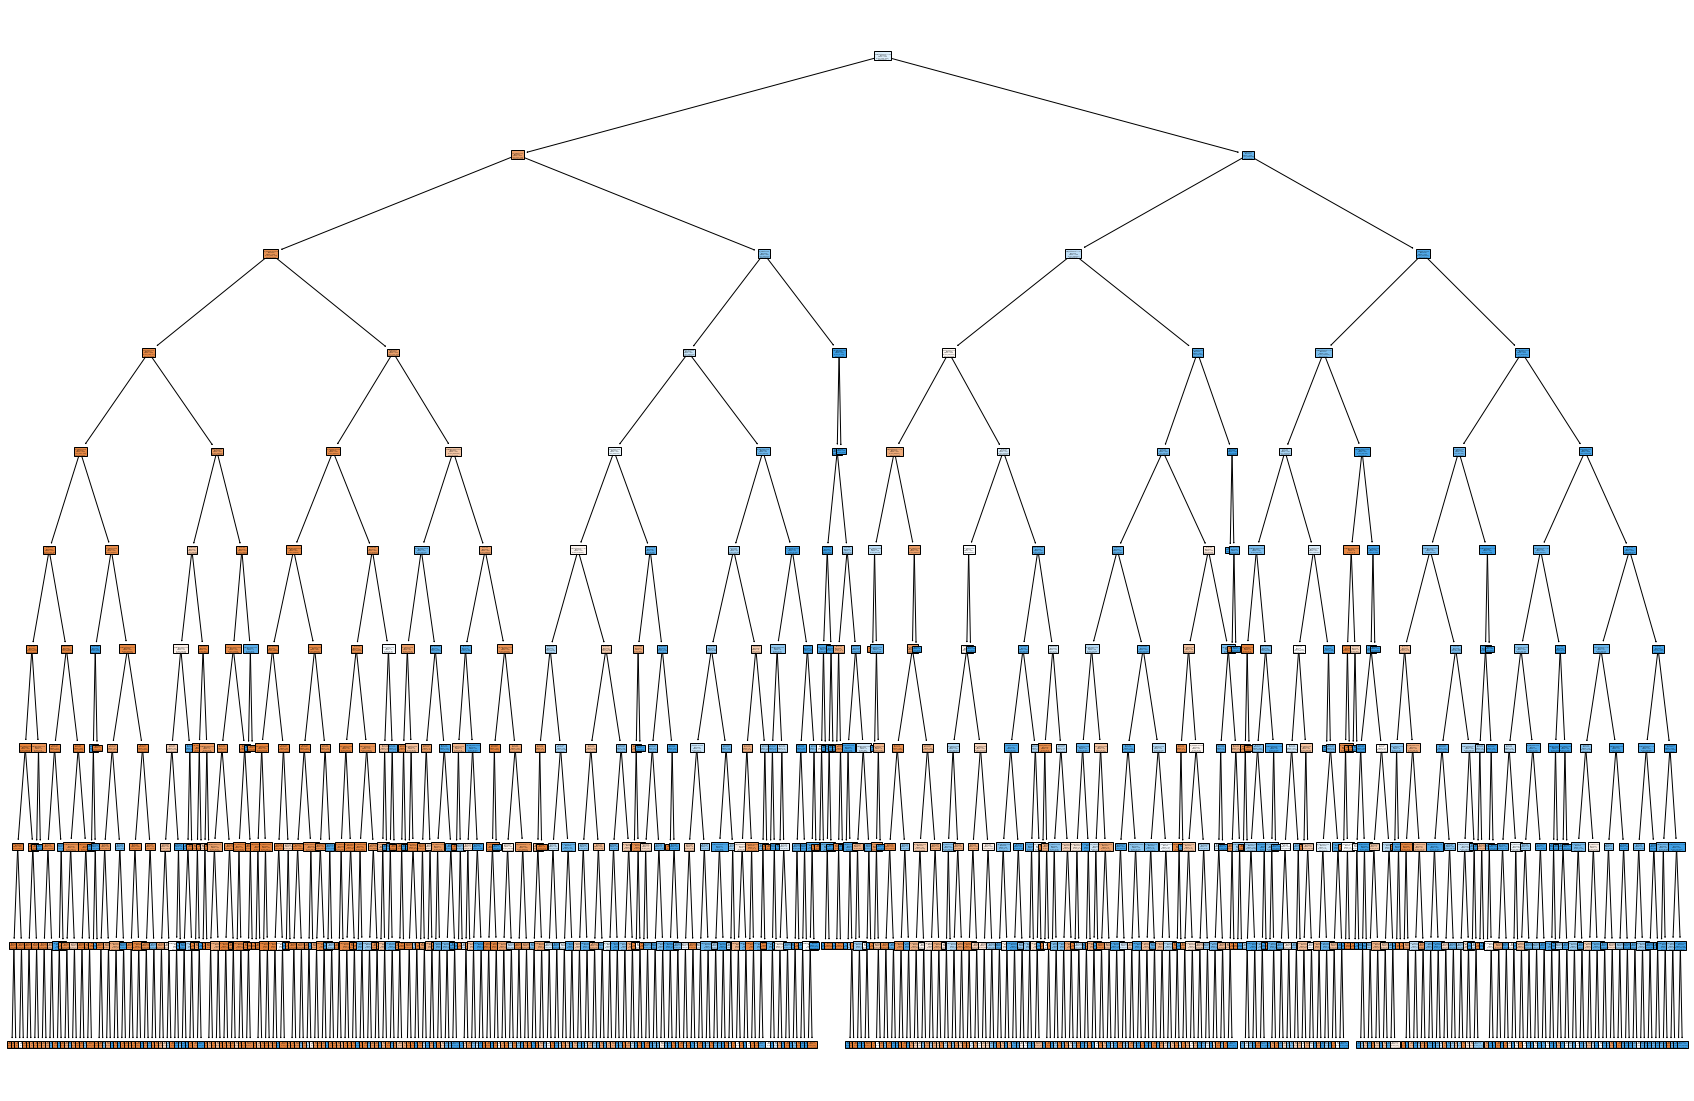

In [52]:
plt.figure(figsize=(30, 20))
plot_tree(dt_model, feature_names=feature_col_names, class_names=['dissatisfied', 'Satisfied'], filled=True);

In [53]:
print(export_text(dt_model, feature_names=feature_col_names, show_weights=True))

|--- Inflight_entertainment <= 3.23
|   |--- Seat_comfort <= 3.50
|   |   |--- On_board_service <= 3.73
|   |   |   |--- Checkin_service <= 4.50
|   |   |   |   |--- Seat_comfort <= 2.48
|   |   |   |   |   |--- EOOB <= 1.50
|   |   |   |   |   |   |--- OS <= 4.50
|   |   |   |   |   |   |   |--- Seat_comfort <= 1.50
|   |   |   |   |   |   |   |   |--- Cleanliness <= 4.50
|   |   |   |   |   |   |   |   |   |--- BH <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- weights: [766.00, 1.00] class: 0
|   |   |   |   |   |   |   |   |   |--- BH >  1.50
|   |   |   |   |   |   |   |   |   |   |--- weights: [1220.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Cleanliness >  4.50
|   |   |   |   |   |   |   |   |   |--- FD <= 3.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [37.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |   |--- FD >  3.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [1.00, 1.00] class: 0
|   |   |   |   |   |   |   |--- Seat_comfort >  

In [54]:
# predict values using the training data
dt_predict_train = dt_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, dt_predict_train)

# predict values using the test data
dt_predict_test = dt_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, dt_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 91.50%
Accuracy on testing data: 90.66%


Confucsion Matrix
[[15705  1877]
 [ 1750 19515]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     17582
           1       0.91      0.92      0.91     21265

    accuracy                           0.91     38847
   macro avg       0.91      0.91      0.91     38847
weighted avg       0.91      0.91      0.91     38847



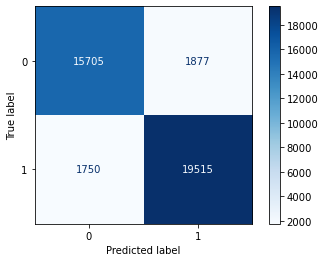

In [55]:
#print("Confucsion Matrix")   # left col predicted false , right predicted true
#print("{0}".format(metrics.confusion_matrix(y_test, dt_predict_test)))
# plot confusion matrix
confM = metrics.plot_confusion_matrix(dt_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, dt_predict_test))

<a id='KNN'></a>
## 4. K-Nearest Neighbors Algorithm
[Top](#top)

In [56]:
# Create KNeighbors object
knn_model = KNeighborsClassifier() # weights = 'distance' make the training accuracy 100% but doesn't make difference on testing data
knn_model.fit(x_train, y_train.ravel());

models.append(knn_model)
names.append("KNN")

In [57]:
# predict values using the training data
knn_predict_train = knn_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, knn_predict_train)

# predict values using the test data
knn_predict_test = knn_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, knn_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 91.29%
Accuracy on testing data: 87.44%


Confucsion Matrix
[[15575  2007]
 [ 2873 18392]]

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     17582
           1       0.90      0.86      0.88     21265

    accuracy                           0.87     38847
   macro avg       0.87      0.88      0.87     38847
weighted avg       0.88      0.87      0.87     38847



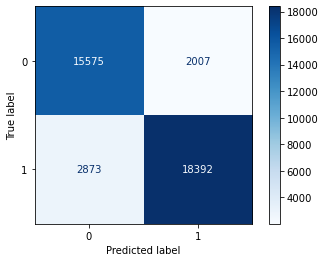

In [58]:
#print("Confucsion Matrix")   # left col predicted false , right predicted true
#print("{0}".format(metrics.confusion_matrix(y_test, knn_predict_test)))
# plot confusion matrix
confM = metrics.plot_confusion_matrix(knn_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, knn_predict_test))

<a id='LR'></a>
## 5. Logistic Regression Algorithm
[Top](#top)

In [59]:
# Create LogisticRegression object
lr_model = LogisticRegression(random_state=seed, max_iter=10000) 
lr_model.fit(x_train, y_train.ravel());

models.append(lr_model)
names.append("LR")

In [60]:
# predict values using the training data
lr_predict_train = lr_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, lr_predict_train)

# predict values using the test data
lr_predict_test = lr_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, lr_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 82.04%
Accuracy on testing data: 81.95%


Confucsion Matrix
[[13692  3890]
 [ 3123 18142]]

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.78      0.80     17582
           1       0.82      0.85      0.84     21265

    accuracy                           0.82     38847
   macro avg       0.82      0.82      0.82     38847
weighted avg       0.82      0.82      0.82     38847



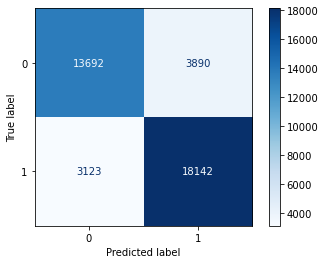

In [61]:
#print("Confucsion Matrix")   # left col predicted false , right predicted true
#print("{0}".format(metrics.confusion_matrix(y_test, lr_predict_test)))
# plot confusion matrix
confM = metrics.plot_confusion_matrix(lr_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

<a id='GB'></a>
## 6. Gradient Boosting Algorithm
[Top](#top)

In [62]:
# Create LogisticRegression object
gb_model = GradientBoostingClassifier(n_estimators=10)
gb_model.fit(x_train, y_train.ravel());

models.append(gb_model)
names.append("GB")

In [63]:
# predict values using the training data
gb_predict_train = gb_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, gb_predict_train)

# predict values using the test data
gb_predict_test = gb_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, gb_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 85.07%
Accuracy on testing data: 84.89%


Confucsion Matrix
[[13722  3860]
 [ 2010 19255]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     17582
           1       0.83      0.91      0.87     21265

    accuracy                           0.85     38847
   macro avg       0.85      0.84      0.85     38847
weighted avg       0.85      0.85      0.85     38847



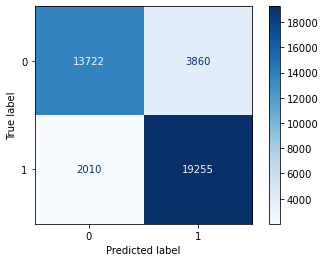

In [64]:
#print("Confucsion Matrix")   # left col predicted false , right predicted true
#print("{0}".format(metrics.confusion_matrix(y_test, gb_predict_test)))
# plot confusion matrix
confM = metrics.plot_confusion_matrix(gb_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, gb_predict_test))

## Algorithms accuracies comparison graph

NB: 0.796293 (0.004593)
RF: 0.927526 (0.002206)
DT: 0.906520 (0.001548)
KNN: 0.876015 (0.004240)
LR: 0.820245 (0.004983)
GB: 0.848058 (0.004521)


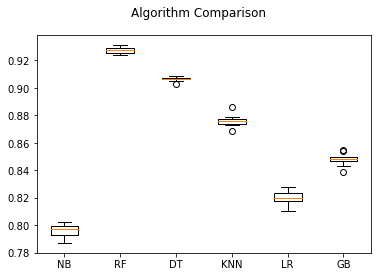

In [65]:

results_ = []
scoring = 'accuracy'
for i, model in enumerate(models):
    kfold = model_selection.KFold(n_splits=10)
    cv_results = None
    if not i:
        cv_results = model_selection.cross_val_score(models[0], x_train_cat, y_train_cat.ravel(), cv=kfold, scoring=scoring)
        results_.append(cv_results)
    else:
        cv_results = model_selection.cross_val_score(model, x_train, y_train.ravel(), cv=kfold, scoring=scoring)
        results_.append(cv_results)
    msg = "%s: %f (%f)" % (names[i], cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_)
ax.set_xticklabels(names)
plt.show()

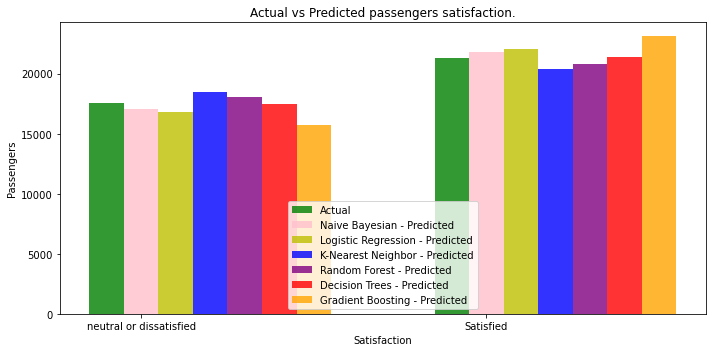

In [66]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(knn_predict_test, return_counts=True)
frequency_predicted_knn = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(dt_predict_test, return_counts=True)
frequency_predicted_dt = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(rf_predict_test, return_counts=True)
frequency_predicted_rf = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(lr_predict_test, return_counts=True)
frequency_predicted_lr = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(nb_predict_test, return_counts=True)
frequency_predicted_nb = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(gb_predict_test, return_counts=True)
frequency_predicted_gb = (occurCount[0], occurCount[1])

n_groups = 2
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')

rects2 = plt.bar(index + bar_width, frequency_predicted_nb, bar_width,
alpha=opacity,
color='pink',
label='Naive Bayesian - Predicted')

rects3 = plt.bar(index + bar_width*2, frequency_predicted_lr, bar_width,
alpha=opacity,
color='y',
label='Logistic Regression - Predicted')

rects4 = plt.bar(index + bar_width*3, frequency_predicted_knn, bar_width,
alpha=opacity,
color='b',
label='K-Nearest Neighbor - Predicted')

rects5 = plt.bar(index + bar_width*4, frequency_predicted_rf, bar_width,
alpha=opacity,
color='purple',
label='Random Forest - Predicted')

rects6 = plt.bar(index + bar_width*5, frequency_predicted_dt, bar_width,
alpha=opacity,
color='red',
label='Decision Trees - Predicted')

rects7 = plt.bar(index + bar_width*6, frequency_predicted_gb, bar_width,
alpha=opacity,
color='orange',
label='Gradient Boosting - Predicted')

plt.xlabel('Satisfaction')
plt.ylabel('Passengers')
plt.title('Actual vs Predicted passengers satisfaction.')
plt.xticks(index + bar_width, ('neutral or dissatisfied', 'Satisfied'))
plt.legend()

plt.tight_layout()
plt.show()

<a id='assoc'></a>
## Association Rule Mining
[Start from here if you have encoded dataset](#check_point)

In [67]:
df_assoc.head()

id satisfaction_v2  Gender  Customer Type  Age  Type of Travel  Class  \
0   11112       satisfied       0              1   65               1      1   
1  110278       satisfied       1              1   47               1      0   
2  103199       satisfied       0              1   15               1      1   
3   47462       satisfied       0              1   60               1      1   
4  120011       satisfied       0              1   70               1      1   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  ...  \
0              265             0                                  0  ...   
1             2464             0                                  0  ...   
2             2138             0                                  0  ...   
3              623             0                                  0  ...   
4              354             0                                  0  ...   

   Online support  Ease of Online booking  On-board service  Leg room service  \
0               2                       3                 3                 0   
1               2                       3                 4                 4   
2               2                       2                 3                 3   
3               3                       1                 1                 0   
4               4                       2                 2                 0   

   Baggage handling  Checkin service  Cleanliness  Online boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   

   Departure Delay in Minutes  Arrival Delay in Minutes  
0                           0                       0.0  
1                         310                     305.0  
2                           0                       0.0  
3                           0                       0.0  
4                           0                       0.0  

[5 rows x 24 columns]

In [68]:
df_assoc.drop(["satisfaction_v2", 'id'], inplace = True, axis=1)
df_assoc.head()

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       0              1   65               1      1              265   
1       1              1   47               1      0             2464   
2       0              1   15               1      1             2138   
3       0              1   60               1      1              623   
4       0              1   70               1      1              354   

   Seat comfort  Departure/Arrival time convenient  Food and drink  \
0             0                                  0               0   
1             0                                  0               0   
2             0                                  0               0   
3             0                                  0               0   
4             0                                  0               0   

   Gate location  ...  Online support  Ease of Online booking  \
0              2  ...               2                       3   
1              3  ...               2                       3   
2              3  ...               2                       2   
3              3  ...               3                       1   
4              3  ...               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

In [69]:
df_assoc.shape

(129880, 22)

In [70]:
df_assoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  int64  
 1   Customer Type                      129880 non-null  int64  
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  int64  
 4   Class                              129880 non-null  int64  
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

In [71]:
df_assoc.isnull().values.any()   # check if there are any null values exist

True

In [72]:
df_assoc = df_assoc.dropna() # drop all nan values

In [73]:
df_assoc.isnull().values.any()   # check if there are any null values exist

False

In [74]:
df_assoc.shape

(129487, 22)

In [75]:
df_assoc.rename(columns={"Food and drink":'Food&Drink',"Online boarding":'Online_boarding',
                   'Ease of Online booking':'Online_booking','Online support':'Online_support', 
                   'Baggage handling':'Baggage_handling', 
                   'Customer Type':'Customer_Type','Type of Travel':'Type_of_Travel',
                   'Flight Distance':'Flight_Distance','Seat comfort':'Seat_comfort',
                  'Departure/Arrival time convenient':'Time_convenient','Gate location':'Gate_location',
                  'Inflight wifi service':'Inflight_wifi_service',
                  'Inflight entertainment':'Inflight_entertainment',
                  'On-board service':'On_board_service', 'Leg room service':'Leg_room_service',
                  'Checkin service':'Checkin_service','Arrival Delay in Minutes':'Arrival_Delay', 
                  'Departure Delay in Minutes': 'Departure_Delay'}
          ,inplace=True)

In [76]:
df_assoc.head()

Gender  Customer_Type  Age  Type_of_Travel  Class  Flight_Distance  \
0       0              1   65               1      1              265   
1       1              1   47               1      0             2464   
2       0              1   15               1      1             2138   
3       0              1   60               1      1              623   
4       0              1   70               1      1              354   

   Seat_comfort  Time_convenient  Food&Drink  Gate_location  ...  \
0             0                0           0              2  ...   
1             0                0           0              3  ...   
2             0                0           0              3  ...   
3             0                0           0              3  ...   
4             0                0           0              3  ...   

   Online_support  Online_booking  On_board_service  Leg_room_service  \
0               2               3                 3                 0   
1               2               3                 4                 4   
2               2               2                 3                 3   
3               3               1                 1                 0   
4               4               2                 2                 0   

   Baggage_handling  Checkin_service  Cleanliness  Online_boarding  \
0                 3                5            3                2   
1                 4                2            3                2   
2                 4                4            4                2   
3                 1                4            1                3   
4                 2                4            2                5   

   Departure_Delay  Arrival_Delay  
0                0            0.0  
1              310          305.0  
2                0            0.0  
3                0            0.0  
4                0            0.0  

[5 rows x 22 columns]

In [77]:
cell = 'Class'
df_assoc = df_assoc.merge(df_assoc[cell].apply(lambda s: pd.Series({'Eco_Class': int(s == 1), 'Eco_Plus_Class': int(s == 2), 'Business_Class': int(s == 0)})), 
                        left_index=True, right_index=True)

In [78]:
cell = 'Flight_Distance'
mean = df_assoc[cell].mean()
df_assoc = df_assoc.merge(df_assoc[cell].apply(lambda s: pd.Series({'ShortTrip': int(s < mean - (mean/4)), 'LongTrip': int(mean - (mean/4) <= s < mean + (mean/2)), 'VeryLongTrip': int(s >= mean + (mean/2))})), 
                        left_index=True, right_index=True)

In [79]:
rate_features = ['Food&Drink', 'Online_booking', 'On_board_service', 'Checkin_service', 'Inflight_entertainment']
for feature in rate_features:
    df_assoc = expandRate(df_assoc, feature)

In [80]:
drop_features = ['Gender', 'Customer_Type', 'Age', 'Departure_Delay', 
                 'Arrival_Delay', 'Type_of_Travel', 'Flight_Distance', 'Class',
                 'Online_support', 'Online_boarding'
                ]
df_assoc.drop(drop_features, inplace = True, axis=1)
df_assoc.drop(rate_features, inplace = True, axis=1)

In [81]:
# if I decide to remove unnecessary features from association after adding them
e = 'Excellent'
g = 'Good'
b = 'Bad'
cells = []
drops = []
for cell in cells:
    drops.append(e+cell)
    drops.append(g+cell)
    drops.append(b+cell)
df_assoc.drop(drops, inplace=True, axis=1)

In [82]:
df_assoc.shape

(129487, 28)

In [83]:
df_assoc.head()

Seat_comfort  Time_convenient  Gate_location  Inflight_wifi_service  \
0             0                0              2                      2   
1             0                0              3                      0   
2             0                0              3                      2   
3             0                0              3                      3   
4             0                0              3                      4   

   Leg_room_service  Baggage_handling  Cleanliness  Eco_Class  Eco_Plus_Class  \
0                 0                 3            3          1               0   
1                 4                 4            3          0               0   
2                 3                 4            4          1               0   
3                 0                 1            1          1               0   
4                 0                 2            2          1               0   

   Business_Class  ...  BadOnline_booking  ExcellentOn_board_service  \
0               0  ...                  0                          0   
1               1  ...                  0                          1   
2               0  ...                  0                          0   
3               0  ...                  1                          0   
4               0  ...                  0                          0   

   GoodOn_board_service  BadOn_board_service  ExcellentCheckin_service  \
0                     1                    0                         1   
1                     0                    0                         0   
2                     1                    0                         1   
3                     0                    1                         1   
4                     1                    0                         1   

   GoodCheckin_service  BadCheckin_service  ExcellentInflight_entertainment  \
0                    0                   0                                1   
1                    1                   0                                0   
2                    0                   0                                0   
3                    0                   0                                1   
4                    0                   0                                0   

   GoodInflight_entertainment  BadInflight_entertainment  
0                           0                          0  
1                           1                          0  
2                           0                          1  
3                           0                          0  
4                           1                          0  

[5 rows x 28 columns]

_Save the encoded dataset to save a lot of time in the next time_

In [84]:
df_assoc.to_csv(r'Passenger_satisfaction_encoded.csv')

<a id='check_point'></a>
[Top](#assoc)

In [85]:
df_assoc = pd.read_csv('Passenger_satisfaction_encoded.csv')
df_assoc = df_assoc.drop('Unnamed: 0',axis=1)

In [86]:
df_assoc.shape

(129487, 28)

In [87]:
df_assoc.head()

Seat_comfort  Time_convenient  Gate_location  Inflight_wifi_service  \
0             0                0              2                      2   
1             0                0              3                      0   
2             0                0              3                      2   
3             0                0              3                      3   
4             0                0              3                      4   

   Leg_room_service  Baggage_handling  Cleanliness  Eco_Class  Eco_Plus_Class  \
0                 0                 3            3          1               0   
1                 4                 4            3          0               0   
2                 3                 4            4          1               0   
3                 0                 1            1          1               0   
4                 0                 2            2          1               0   

   Business_Class  ...  BadOnline_booking  ExcellentOn_board_service  \
0               0  ...                  0                          0   
1               1  ...                  0                          1   
2               0  ...                  0                          0   
3               0  ...                  1                          0   
4               0  ...                  0                          0   

   GoodOn_board_service  BadOn_board_service  ExcellentCheckin_service  \
0                     1                    0                         1   
1                     0                    0                         0   
2                     1                    0                         1   
3                     0                    1                         1   
4                     1                    0                         1   

   GoodCheckin_service  BadCheckin_service  ExcellentInflight_entertainment  \
0                    0                   0                                1   
1                    1                   0                                0   
2                    0                   0                                0   
3                    0                   0                                1   
4                    0                   0                                0   

   GoodInflight_entertainment  BadInflight_entertainment  
0                           0                          0  
1                           1                          0  
2                           0                          1  
3                           0                          0  
4                           1                          0  

[5 rows x 28 columns]

In [88]:
records = []
for _, row in df_assoc.iterrows():
    x = row[(row == 1)]
    records.append(x.index.to_list())

In [89]:
print(records[:5])
len(records)

[['Eco_Class', 'ShortTrip', 'BadFood&Drink', 'GoodOnline_booking', 'GoodOn_board_service', 'ExcellentCheckin_service', 'ExcellentInflight_entertainment'], ['Business_Class', 'LongTrip', 'BadFood&Drink', 'GoodOnline_booking', 'ExcellentOn_board_service', 'GoodCheckin_service', 'GoodInflight_entertainment'], ['Eco_Class', 'LongTrip', 'BadFood&Drink', 'GoodOnline_booking', 'GoodOn_board_service', 'ExcellentCheckin_service', 'BadInflight_entertainment'], ['Baggage_handling', 'Cleanliness', 'Eco_Class', 'ShortTrip', 'BadFood&Drink', 'BadOnline_booking', 'BadOn_board_service', 'ExcellentCheckin_service', 'ExcellentInflight_entertainment'], ['Eco_Class', 'ShortTrip', 'BadFood&Drink', 'GoodOnline_booking', 'GoodOn_board_service', 'ExcellentCheckin_service', 'GoodInflight_entertainment']]


129487

In [90]:
association_rules = apriori(records, min_support=0.02, min_confidence=0.5, min_lift=3, min_length=2)

In [91]:
while True:
    try:
        item = next(association_rules)
    except:
        break
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: BadFood&Drink -> BadInflight_entertainment
Support: 0.08201595526964096
Confidence: 0.7206840390879479
Lift: 3.465251175988901
Rule: BadFood&Drink -> Gate_location
Support: 0.11352490983650869
Confidence: 0.545859636093576
Lift: 3.141828986035866
Rule: BadFood&Drink -> Seat_comfort
Support: 0.12167244588259825
Confidence: 0.5850352766431489
Lift: 3.6277398173877704
Rule: Time_convenient -> BadFood&Drink
Support: 0.11670669642512375
Confidence: 0.5611585592276271
Lift: 3.498278289861237
Rule: BadInflight_entertainment -> Seat_comfort
Support: 0.06754345996123164
Confidence: 0.593512486427796
Lift: 3.680306068866776
Rule: Inflight_wifi_service -> BadOnline_booking
Support: 0.07992308108149852
Confidence: 0.7714498695490122
Lift: 6.80932033117198
Rule: Gate_location -> Seat_comfort
Support: 0.0858387328457683
Confidence: 0.5322766018580596
Lift: 3.0636485017911084
Rule: Time_convenient -> Gate_location
Support: 0.11458293110505302
Confidence: 0.6595101569098102
Lift: 4.1114049245477

Rule: ShortTrip -> BadFood&Drink
Support: 0.0326133125333045
Confidence: 0.5251834348961573
Lift: 3.256605087367049
Rule: Time_convenient -> BadFood&Drink
Support: 0.08221674762717493
Confidence: 0.5098170673307154
Lift: 4.368361738846767
Rule: Time_convenient -> BadFood&Drink
Support: 0.035679257377188446
Confidence: 0.5745554035567716
Lift: 3.581794595366409
Rule: VeryLongTrip -> Time_convenient
Support: 0.02153884173700835
Confidence: 0.6591822264240134
Lift: 4.109360596647548
Rule: Inflight_wifi_service -> BadInflight_entertainment
Support: 0.02605666978152247
Confidence: 0.9504225352112676
Lift: 8.389049953435679
Rule: BadInflight_entertainment -> BadOnline_booking
Support: 0.022048545413825327
Confidence: 0.8042253521126761
Lift: 4.9869135221249925
Rule: Eco_Class -> BadInflight_entertainment
Support: 0.044212932572381784
Confidence: 0.6306455166336198
Lift: 3.910563931248804
Rule: ExcellentCheckin_service -> BadInflight_entertainment
Support: 0.026743997466927183
Confidence: 0.5

Rule: GoodOnline_booking -> Time_convenient
Support: 0.030296477638681877
Confidence: 0.5647041888585
Lift: 3.520381845010861
Rule: Time_convenient -> LongTrip
Support: 0.05274660776757512
Confidence: 0.5702596643566836
Lift: 3.5550148359998985
Rule: ShortTrip -> Gate_location
Support: 0.027578058028991326
Confidence: 0.5250698426701955
Lift: 3.2559007143873004
Rule: Time_convenient -> Gate_location
Support: 0.07794604863808723
Confidence: 0.9080521817363922
Lift: 5.660822919286516
Rule: Time_convenient -> Gate_location
Support: 0.03866797439125163
Confidence: 0.7362152624614027
Lift: 4.589586716592347
Rule: VeryLongTrip -> Time_convenient
Support: 0.023168348946226262
Confidence: 0.8066684592632428
Lift: 5.0287939331096005
Rule: Time_convenient -> GoodCheckin_service
Support: 0.034544008278823354
Confidence: 0.5509299174775218
Lift: 3.43451264861643
Rule: Time_convenient -> LongTrip
Support: 0.04774996717817233
Confidence: 0.5356957199792064
Lift: 3.3395422316184824
Rule: Time_conveni

Rule: Eco_Class -> Seat_comfort
Support: 0.024048746206182862
Confidence: 0.5742209109349069
Lift: 3.5606811174326354
Rule: Eco_Class -> BadFood&Drink
Support: 0.026195679875199825
Confidence: 0.5905292479108635
Lift: 3.6618073328337313
Rule: Eco_Class -> BadFood&Drink
Support: 0.026180234309235675
Confidence: 0.56841046277666
Lift: 3.5246511633733055
Rule: Eco_Class -> Time_convenient
Support: 0.023392309652706448
Confidence: 0.5078806170355467
Lift: 3.166142095136576
Rule: Eco_Class -> Time_convenient
Support: 0.02823449458246774
Confidence: 0.7659752776031846
Lift: 4.77511149058801
Rule: Eco_Class -> GoodCheckin_service
Support: 0.02084379126862156
Confidence: 0.5611226611226611
Lift: 3.4794603017330723
Rule: Eco_Class -> LongTrip
Support: 0.035849158602794105
Confidence: 0.5530799475753605
Lift: 4.885841395257928
Rule: Eco_Class -> Time_convenient
Support: 0.022473298477839476
Confidence: 0.5638442162371634
Lift: 3.496336367584598
Rule: ExcellentCheckin_service -> BadFood&Drink
Sup

Rule: Time_convenient -> BadFood&Drink
Support: 0.05629908793932982
Confidence: 0.6293162983425414
Lift: 5.392289539669181
Rule: Time_convenient -> BadFood&Drink
Support: 0.02300617050360268
Confidence: 0.6485956890920966
Lift: 4.043363824248631
Rule: Gate_location -> BadFood&Drink
Support: 0.026674492420088503
Confidence: 0.6281142025822877
Lift: 3.6152653131427606
Rule: Gate_location -> LongTrip
Support: 0.03466757280653656
Confidence: 0.5830627354201844
Lift: 3.355960546799725
Rule: Gate_location -> BadFood&Drink
Support: 0.05619869176056284
Confidence: 0.542533363155148
Lift: 4.458966524587156
Rule: Gate_location -> BadFood&Drink
Support: 0.02548518384084889
Confidence: 0.7007857294542367
Lift: 4.033544105873705
Rule: Time_convenient -> Gate_location
Support: 0.06596028944990617
Confidence: 0.5739147963983336
Lift: 5.008728532805218
Rule: GoodCheckin_service -> BadFood&Drink
Support: 0.02742360236934982
Confidence: 0.6457537734133479
Lift: 4.004248580498716
Rule: Time_convenient ->

Rule: ExcellentCheckin_service -> Business_Class
Support: 0.0376408442546356
Confidence: 0.7407294832826746
Lift: 4.593182578384431
Rule: Time_convenient -> ExcellentCheckin_service
Support: 0.039486589387351625
Confidence: 0.5322714969810536
Lift: 5.833452334285712
Rule: Time_convenient -> ExcellentCheckin_service
Support: 0.039038667974391254
Confidence: 0.5262336039975016
Lift: 6.09375878025617
Rule: Business_Class -> ExcellentInflight_entertainment
Support: 0.050723238626271365
Confidence: 0.5559035124841304
Lift: 7.828415238828994
Rule: Time_convenient -> Business_Class
Support: 0.05295512290809116
Confidence: 0.5803639441388067
Lift: 6.436795377704638
Rule: Time_convenient -> Business_Class
Support: 0.04925590985967703
Confidence: 0.5703809694151315
Lift: 6.32607456845029
Rule: Business_Class -> ExcellentOn_board_service
Support: 0.04765729378238742
Confidence: 0.5223021582733813
Lift: 5.83834077765412
Rule: Time_convenient -> Business_Class
Support: 0.04882343401268081
Confidenc

Rule: Time_convenient -> GoodCheckin_service
Support: 0.020704781174944203
Confidence: 0.860397946084724
Lift: 5.363745069793108
Rule: Time_convenient -> LongTrip
Support: 0.026550927892375297
Confidence: 0.8904428904428905
Lift: 5.551046100562253
Rule: Time_convenient -> ShortTrip
Support: 0.021608346783847026
Confidence: 0.8520097442143726
Lift: 5.311452782681934
Rule: Gate_location -> ExcellentOn_board_service
Support: 0.05898661641709206
Confidence: 0.5681344837845879
Lift: 6.495896680071958
Rule: Time_convenient -> Gate_location
Support: 0.06590622996903164
Confidence: 0.6347813150847962
Lift: 6.506445669784295
Rule: Time_convenient -> ExcellentOn_board_service
Support: 0.05855414057009584
Confidence: 0.6545234806629834
Lift: 6.708800913528673
Rule: GoodCheckin_service -> ExcellentOn_board_service
Support: 0.022272506120305513
Confidence: 0.6004580470539247
Lift: 3.7233747312935326
Rule: Time_convenient -> GoodCheckin_service
Support: 0.025909936904863037
Confidence: 0.69852175723

Rule: Business_Class -> BadFood&Drink
Support: 0.04473035903218084
Confidence: 0.5224607613205845
Lift: 7.197008149055162
Rule: Business_Class -> BadFood&Drink
Support: 0.04161807749040444
Confidence: 0.5860793909733552
Lift: 8.540362603980062
Rule: Business_Class -> BadFood&Drink
Support: 0.041834315413902555
Confidence: 0.6805276381909547
Lift: 6.569707171134881
Rule: Business_Class -> BadFood&Drink
Support: 0.04086124475816105
Confidence: 0.6646984924623116
Lift: 7.599983549092038
Rule: Business_Class -> BadFood&Drink
Support: 0.040583224570806334
Confidence: 0.6601758793969849
Lift: 6.7667374412631505
Rule: Business_Class -> BadFood&Drink
Support: 0.04052916508993181
Confidence: 0.6592964824120603
Lift: 7.680640901312681
Rule: Business_Class -> BadFood&Drink
Support: 0.04138639400094218
Confidence: 0.6732412060301507
Lift: 5.875580241640906
Rule: Business_Class -> BadFood&Drink
Support: 0.02084379126862156
Confidence: 0.535409640944257
Lift: 4.745932925585228
Rule: Business_Class -

Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.04715531288855252
Confidence: 0.5032970656116057
Lift: 7.017382053930223
Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.020890127966514013
Confidence: 0.5228063393892539
Lift: 5.87236506492855
Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.041641245839350666
Confidence: 0.5864056552474171
Lift: 8.528800301136952
Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.020218245847073452
Confidence: 0.6329787234042553
Lift: 6.11067739934741
Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.026821225296747936
Confidence: 0.6712408194820255
Lift: 6.480053678690005
Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.04699313444592893
Confidence: 0.5015661061655127
Lift: 7.6335555229259215
Rule: BadFood&Drink -> ExcellentInflight_entertainment
Support: 0.020195077498127226
Confidence: 0.5865859129654554
Lift: 5.6628084777572445
Rule: BadFood&Drink ->

Rule: ExcellentCheckin_service -> Business_Class
Support: 0.03159390517967055
Confidence: 0.6888365044620307
Lift: 7.639860595569591
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.029300238633994145
Confidence: 0.576595744680851
Lift: 6.44523939843658
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.028968158965764903
Confidence: 0.5700607902735562
Lift: 6.403145519617624
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.029995289102380935
Confidence: 0.6539821518774205
Lift: 7.345783041303916
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.0307907357495347
Confidence: 0.6059270516717324
Lift: 6.928006723162703
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.030435487732359233
Confidence: 0.5989361702127659
Lift: 6.139036481622767
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.030867963579355458
Confidence: 0.6730089240612898
Lift: 6.898274879278416
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.0361349

Rule: ExcellentCheckin_service -> Gate_location
Support: 0.020635276128105524
Confidence: 0.546644844517185
Lift: 6.368277191362728
Rule: ExcellentInflight_entertainment -> Gate_location
Support: 0.049974128677010045
Confidence: 0.7037520391517129
Lift: 8.581480393034923
Rule: ExcellentInflight_entertainment -> Gate_location
Support: 0.05452284785345247
Confidence: 0.527811004784689
Lift: 6.996075706475077
Rule: ExcellentInflight_entertainment -> ExcellentOnline_booking
Support: 0.04845274042954119
Confidence: 0.6823273518216422
Lift: 9.044172566826592
Rule: ExcellentInflight_entertainment -> Gate_location
Support: 0.021994485932950798
Confidence: 0.7376327376327376
Lift: 7.104570834413143
Rule: ExcellentInflight_entertainment -> Gate_location
Support: 0.02458934101492814
Confidence: 0.594695554725439
Lift: 5.727859513145858
Rule: ExcellentInflight_entertainment -> Gate_location
Support: 0.04903967193617892
Confidence: 0.6905927134312126
Lift: 9.628812176598194
Rule: ExcellentInflight_

Rule: ExcellentCheckin_service -> Business_Class
Support: 0.024566172665981913
Confidence: 0.5328308207705192
Lift: 7.621193470574641
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.02571686733031115
Confidence: 0.5607004546219903
Lift: 8.15493875857999
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.026180234309235675
Confidence: 0.5151975683890577
Lift: 6.815630112177556
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.02578637237714983
Confidence: 0.5074468085106383
Lift: 6.870322552657572
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.026326967185895108
Confidence: 0.5740023572992086
Lift: 7.771418155541888
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.030651725655857345
Confidence: 0.5619425173439049
Lift: 7.209377860230873
Rule: Business_Class -> BadFood&Drink
Support: 0.03516955370037147
Confidence: 0.5577464788732395
Lift: 6.801103522917333
Rule: Business_Class -> BadFood&Drink
Support: 0.033725393282723365
Confidenc

Rule: BadFood&Drink -> Gate_location
Support: 0.02253508074169608
Confidence: 0.5010302197802198
Lift: 7.166342656432268
Rule: BadFood&Drink -> Gate_location
Support: 0.024442608138268707
Confidence: 0.5633677465290139
Lift: 7.59725050976905
Rule: BadFood&Drink -> Gate_location
Support: 0.047425610292925156
Confidence: 0.5301277624309392
Lift: 8.037074531541391
Rule: BadFood&Drink -> Gate_location
Support: 0.021222207634743254
Confidence: 0.5983017635532331
Lift: 7.691848734830966
Rule: BadFood&Drink -> ExcellentOnline_booking
Support: 0.022990724937638526
Confidence: 0.5299038803844784
Lift: 7.010182239409987
Rule: BadFood&Drink -> Gate_location
Support: 0.022403793431000796
Confidence: 0.5163759344962621
Lift: 7.010271611461258
Rule: BadFood&Drink -> Gate_location
Support: 0.022975279371674377
Confidence: 0.5108173076923077
Lift: 5.273816035811979
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.025763204028203604
Confidence: 0.5069908814589665
Lift: 9.77206434466764
Rule:

Rule: ExcellentCheckin_service -> Business_Class
Support: 0.021917258103130045
Confidence: 0.5011478015186297
Lift: 11.125000064331015
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.021338049379474387
Confidence: 0.5450779246399684
Lift: 7.5999251887429295
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.02112953423895835
Confidence: 0.5397514302623792
Lift: 8.264253689296996
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.02376300323584607
Confidence: 0.5181006903519111
Lift: 8.77991154189215
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.023237853993064942
Confidence: 0.5040201005025127
Lift: 8.541297049308842
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.022936665456764
Confidence: 0.5000841892574508
Lift: 8.979947498873878
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.0266127101562319
Confidence: 0.5237082066869301
Lift: 9.881014798086918
Rule: ExcellentCheckin_service -> Business_Class
Support: 0.02378617

## Data Visualization Bussiness Part ( skipped to be done in R language )

In [92]:
# Visualizing Gender satisification of the 
# 

'''
dataset_satisification_Gender = df[df["satisfaction_v2"] == 1]
dataset_satisification_Gender.Gender.value_counts(normalize = False).plot.bar(title="satisifaction level")
'''

'\ndataset_satisification_Gender = df[df["satisfaction_v2"] == 1]\ndataset_satisification_Gender.Gender.value_counts(normalize = False).plot.bar(title="satisifaction level")\n'

In [93]:
# Visualizing Gender dissatisification of the 
# 
'''
dataset_satisification_Gender = df[df["satisfaction_v2"] == 0]
dataset_satisification_Gender.Gender.value_counts(normalize = False).plot.bar(title="satisifaction level")
'''



'\ndataset_satisification_Gender = df[df["satisfaction_v2"] == 0]\ndataset_satisification_Gender.Gender.value_counts(normalize = False).plot.bar(title="satisifaction level")\n'

In [94]:
#groupByCleanliness = df.groupby("Cleanliness")

## Exporting data to a csv form

In [95]:
df.to_csv(r'Passenger_satisfaction_processed.csv')

# Pyspark Implementation

In [3]:
import pandas as pd

In [4]:
dataset = pd.read_csv("Airline_Dataset.csv")
dataset.head()

id  Gender      Customer Type  Age   Type of Travel     Class  \
0   70172    Male     Loyal Customer   13  Personal Travel  Eco Plus   
1    5047    Male  disloyal Customer   25  Business travel  Business   
2  110028  Female     Loyal Customer   26  Business travel  Business   
3   24026  Female     Loyal Customer   25  Business travel  Business   
4  119299    Male     Loyal Customer   61  Business travel  Business   

   Flight Distance  Inflight wifi service  Departure/Arrival time convenient  \
0              460                      3                                  4   
1              235                      3                                  2   
2             1142                      2                                  2   
3              562                      2                                  5   
4              214                      3                                  3   

   Ease of Online booking  ...  Inflight entertainment  On-board service  \
0                       3  ...                       5                 4   
1                       3  ...                       1                 1   
2                       2  ...                       5                 4   
3                       5  ...                       2                 2   
4                       3  ...                       3                 3   

   Leg room service  Baggage handling  Checkin service  Inflight service  \
0                 3                 4                4                 5   
1                 5                 3                1                 4   
2                 3                 4                4                 4   
3                 5                 3                1                 4   
4                 4                 4                3                 3   

   Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
0            5                          25                      18.0   
1            1                           1                       6.0   
2            5                           0                       0.0   
3            2                          11                       9.0   
4            3                           0                       0.0   

              Satisfaction  
0  neutral or dissatisfied  
1  neutral or dissatisfied  
2                satisfied  
3  neutral or dissatisfied  
4                satisfied  

[5 rows x 24 columns]

In [5]:
dataset.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
Satisfaction                           0
dtype: int64

In [6]:
dataset.dropna(inplace=True)
dataset.isnull().sum()

id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Satisfaction                         0
dtype: int64

In [7]:
dataset.drop(['id','Class', 'Type of Travel','Gender'],axis=1,inplace=True)
dataset.to_csv("cleaned_Dataset.csv")

In [78]:
sc.stop()
spark.stop()

# ML with Pyspark

In [79]:
# load our pkgs
from pyspark import SparkContext

In [80]:
sc = SparkContext(master='local[2]')

In [81]:
sc

<SparkContext master=local[2] appName=PySparkShell>

In [82]:
# load pkgs
from pyspark.sql import SparkSession
import pandas as pd

In [83]:
# Spark
spark = SparkSession.builder.appName("MLwithSpark").getOrCreate()

#### WorkFlow
+ Data prep
+ Feature Engineering
+ Build Model
+ Evaluate

In [84]:
# Load our dataset
df = spark.read.csv("cleaned_Dataset.csv", header=True, inferSchema=True)

In [85]:
# Preview Dataset
df.show(2)

+---+-----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|_c0|    Customer Type|Age|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        Satisfaction|
+---+-----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+

In [86]:
# Check for columns
print(df.columns)

['_c0', 'Customer Type', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Satisfaction']


In [87]:
# check for datatypes
df.dtypes

[('_c0', 'int'),
 ('Customer Type', 'string'),
 ('Age', 'int'),
 ('Flight Distance', 'int'),
 ('Inflight wifi service', 'int'),
 ('Departure/Arrival time convenient', 'int'),
 ('Ease of Online booking', 'int'),
 ('Gate location', 'int'),
 ('Food and drink', 'int'),
 ('Online boarding', 'int'),
 ('Seat comfort', 'int'),
 ('Inflight entertainment', 'int'),
 ('On-board service', 'int'),
 ('Leg room service', 'int'),
 ('Baggage handling', 'int'),
 ('Checkin service', 'int'),
 ('Inflight service', 'int'),
 ('Cleanliness', 'int'),
 ('Departure Delay in Minutes', 'int'),
 ('Arrival Delay in Minutes', 'double'),
 ('Satisfaction', 'string')]

In [88]:
# check for the schema
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay in Minutes: double (nullable = true)
 |-- Satisf

In [89]:
# Descriptive summary
print(df.describe().show())

+-------+------------------+-----------------+------------------+------------------+---------------------+---------------------------------+----------------------+------------------+------------------+------------------+------------------+----------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------------+------------------------+--------------------+
|summary|               _c0|    Customer Type|               Age|   Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|     Gate location|    Food and drink|   Online boarding|      Seat comfort|Inflight entertainment|  On-board service|  Leg room service| Baggage handling|   Checkin service|  Inflight service|       Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        Satisfaction|
+-------+------------------+-----------------+------------------+------------------+------------------

In [90]:
# Value count
df.groupBy('Satisfaction').count().show()

+--------------------+-----+
|        Satisfaction|count|
+--------------------+-----+
|neutral or dissat...|73225|
|           satisfied|56262|
+--------------------+-----+



#### Feature Engineering
+ Numerical values
+ Vectorization
+ Scaling

In [91]:
# Load ML pkgs
from pyspark.ml.feature import VectorAssembler,StringIndexer

In [92]:
# Encoding for satisfaction
# Label encoding
satEncoding = StringIndexer(inputCol="Satisfaction",outputCol="Target").fit(df)
df = satEncoding.transform(df)

In [93]:
df.show(2)

+---+-----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+------+
|_c0|    Customer Type|Age|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        Satisfaction|Target|
+---+-----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+---

In [94]:
# Get the labels
satEncoding.labels

['neutral or dissatisfied', 'satisfied']

In [95]:
# Encoding for customer type and class
# Label encoding
custEncoding = StringIndexer(inputCol="Customer Type",outputCol="Type of Customer").fit(df)
df = custEncoding.transform(df)

df.show(2)

+---+-----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+------+----------------+
|_c0|    Customer Type|Age|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        Satisfaction|Target|Type of Customer|
+---+-----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+---

In [96]:
### Features
print(df.columns)

['_c0', 'Customer Type', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Satisfaction', 'Target', 'Type of Customer']


In [97]:
df.dtypes

[('_c0', 'int'),
 ('Customer Type', 'string'),
 ('Age', 'int'),
 ('Flight Distance', 'int'),
 ('Inflight wifi service', 'int'),
 ('Departure/Arrival time convenient', 'int'),
 ('Ease of Online booking', 'int'),
 ('Gate location', 'int'),
 ('Food and drink', 'int'),
 ('Online boarding', 'int'),
 ('Seat comfort', 'int'),
 ('Inflight entertainment', 'int'),
 ('On-board service', 'int'),
 ('Leg room service', 'int'),
 ('Baggage handling', 'int'),
 ('Checkin service', 'int'),
 ('Inflight service', 'int'),
 ('Cleanliness', 'int'),
 ('Departure Delay in Minutes', 'int'),
 ('Arrival Delay in Minutes', 'double'),
 ('Satisfaction', 'string'),
 ('Target', 'double'),
 ('Type of Customer', 'double')]

In [98]:
df2 = df.select('Type of Customer', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Target')

In [99]:
df2.printSchema()

root
 |-- Type of Customer: double (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay in Minutes: double (nullable = true)
 |-- Target: double (nullable = false)



In [100]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
df2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df2.columns]).show()

+----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------+
|Type of Customer|Age|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|Target|
+----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+----------

In [101]:
required_features = ['Type of Customer', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Target']

In [102]:
# Vector Asm
vec_assembler = VectorAssembler(inputCols=required_features,outputCol='features',handleInvalid="skip")

In [103]:
vec_df = vec_assembler.transform(df2)

In [104]:
vec_df.show(2)

+----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------+--------------------+
|Type of Customer|Age|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|Target|            features|
+----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+-

### Train,Test Split

In [105]:
train_df,test_df = vec_df.randomSplit([0.6,0.4])

In [106]:
train_df.show(5)

+----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------+--------------------+
|Type of Customer|Age|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|Target|            features|
+----------------+---+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+-

#### Model Building
+ Pyspark.ml: Dataframe
+ Pyspark.mllib: RDD legacy

In [107]:
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier

In [108]:
# Logistic model
lr = LogisticRegression(featuresCol='features',labelCol='Target')

In [109]:
lr_model = lr.fit(train_df)

In [110]:
y_pred = lr_model.transform(test_df)

In [111]:
print(y_pred.columns)

['Type of Customer', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Target', 'features', 'rawPrediction', 'probability', 'prediction']


In [112]:
y_pred.select('Target','rawPrediction', 'probability', 'prediction').show(10)

+------+--------------------+--------------------+----------+
|Target|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+----------+
|   0.0|[21.4291874775231...|[0.99999999950634...|       0.0|
|   0.0|[17.7843770390490...|[0.99999998110516...|       0.0|
|   0.0|[20.7224693053810...|[0.99999999899920...|       0.0|
|   0.0|[17.1674151632025...|[0.99999996498240...|       0.0|
|   0.0|[16.5578767638398...|[0.99999993558226...|       0.0|
|   0.0|[15.5272436832605...|[0.99999981944743...|       0.0|
|   0.0|[17.6536346742091...|[0.99999997846604...|       0.0|
|   0.0|[18.1961942445054...|[0.99999998748320...|       0.0|
|   0.0|[20.5119962721458...|[0.99999999876475...|       0.0|
|   0.0|[17.3092896204382...|[0.99999996961417...|       0.0|
+------+--------------------+--------------------+----------+
only showing top 10 rows



#### Model Evaluation

In [113]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [114]:
# Check for accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol='Target',metricName='accuracy',predictionCol='prediction')

In [115]:
multi_evaluator.evaluate(y_pred)

1.0

## K means Clustering model

In [116]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol=vec_assembler.getOutputCol(),predictionCol="cluster", k=2)
model = kmeans.fit(vec_df)
print("Model is successfully trained!")

Model is successfully trained!


## Centroid of each cluster

In [117]:
centers = model.clusterCenters()
print("Clsuter Centers: ")
for center in centers:
    print(center)

Clsuter Centers: 
[2.38553022e-01 3.83688254e+01 6.64565242e+02 2.72605342e+00
 3.08650001e+00 2.70968627e+00 2.97035763e+00 3.16076950e+00
 3.08782964e+00 3.31815160e+00 3.25292572e+00 3.30128848e+00
 3.24634087e+00 3.59074744e+00 3.25687241e+00 3.60650254e+00
 3.21227694e+00 1.47320790e+01 1.52439876e+01 3.46369364e-01]
[3.19087663e-02 4.23213627e+01 2.62471524e+03 2.73534155e+00
 2.97779634e+00 2.88532427e+00 2.99478747e+00 3.32453058e+00
 3.70271282e+00 3.77845294e+00 3.64500058e+00 3.60675613e+00
 3.63690819e+00 3.74415390e+00 3.44096302e+00 3.74026610e+00
 3.48801981e+00 1.44013363e+01 1.46739719e+01 6.75008640e-01]


## Cluster the data

In [118]:
prediction = model.transform(vec_df)
prediction.groupBy("cluster").count().orderBy("cluster").show()
prediction.select('cluster').show(5)

+-------+-----+
|cluster|count|
+-------+-----+
|      0|94763|
|      1|34724|
+-------+-----+

+-------+
|cluster|
+-------+
|      0|
|      0|
|      0|
|      0|
|      0|
+-------+
only showing top 5 rows



## Naive Bayes Classifier

In [119]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into train and test
splits = vec_df.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol=vec_assembler.getOutputCol(),predictionCol="pred",
               labelCol='Target')

# train the model
model = nb.fit(train)

# select example rows to display.
predictions = model.transform(test)
predictions.select("Target","pred").show(5)

+------+----+
|Target|pred|
+------+----+
|   0.0| 0.0|
|   0.0| 0.0|
|   0.0| 0.0|
|   0.0| 0.0|
|   0.0| 0.0|
+------+----+
only showing top 5 rows



In [120]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="pred",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.6397160931954945
